# We're going to try fitting a full asymptotic relation to some simulated data


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

from utils import gaussian

import pymc3 as pm
import arviz

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Build the model

In [2]:
class model():
    def __init__(self, f, n0_, n1_, n2_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        
    def epsilon(self, i, theano=True):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.cos(i)**2)
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sin(i)**2)
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * (3. * tt.cos(i)**2 - 1.)**2)
        eps2 = tt.set_subtensor(eps2[1], (3./8.)*tt.sin(2*i)**2)
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        if not theano:
            return eps.eval()
        return eps
            

    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        eps = self.epsilon(i, theano)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
               
        #Create the model
        self.mod = self.modes + b
        return self.mod

#     def asymptotic(self, n, numax, deltanu, alpha, epsilon):       
#         nmax = (numax / deltanu) - epsilon
#         over = (n + epsilon + ((alpha/2)*(nmax - n)**2))
#         return over * deltanu

    # Small separations are fractional
    def asymptotic(self, n, numax, deltanu, alpha, epsilon, d=0.): 
        nmax = (numax / deltanu) + epsilon
        curve = (alpha/2.)*(nmax-n)*(nmax-n)
        return (n + epsilon + d + curve) * deltanu

    def f0(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, deltanu, alpha, epsilon, 0.)
    
    def f1(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n1, numax, deltanu, alpha, epsilon, d01)
    
    def f2(self, p):
        numax, deltanu, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n2+1, numax, deltanu, alpha, epsilon, -d02)


In [4]:
nmodes = 4
nbase = 18
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .05
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

In [5]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.01
epsilon_ = 1.1
d01_ = deltanu_/2. / deltanu_
d02_ = 6. / deltanu_

In [6]:
mod = model(ff, n0_, n1_, n2_)

In [8]:
init_f = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_]
f0_ = mod.f0(init_f)
f1_ = mod.f1(init_f)
f2_ = mod.f2(init_f)

In [9]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

And now lets reset the model for the new frequency range...

In [10]:
mod = model(f, n0_, n1_, n2_)

In [11]:
init_m =[f0_,                         # l0 modes
           f1_,                         # l1 modes
           f2_,                         # l2 modes
           np.ones(len(f0_)) * 2.0,     # l0 widths
           np.ones(len(f1_)) * 2.0,     # l1 widths
           np.ones(len(f2_)) * 2.0,     # l2 widths
           np.sqrt(gaussian(f0_, 0, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l0 heights
           np.sqrt(gaussian(f1_, 1, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l1 heights
           np.sqrt(gaussian(f2_, 2, numax_, 1000.) * 2.0 * np.pi / 2.0) ,# l2 heights
           1.,       # splitting
           np.pi/4.,                    # inclination angle
           1.                           # background parameters
        ]
p = mod.model(init_m, theano=False)*np.random.chisquare(2., size=len(f))/2

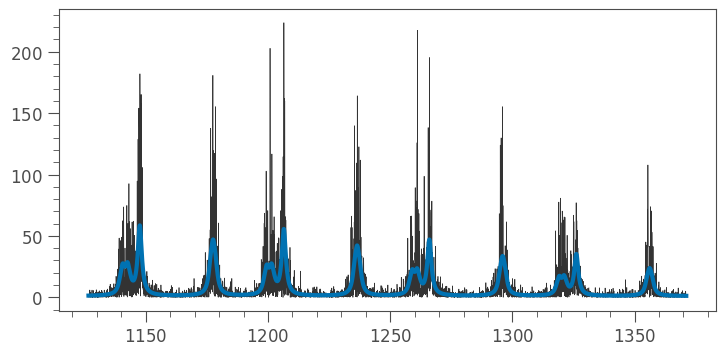

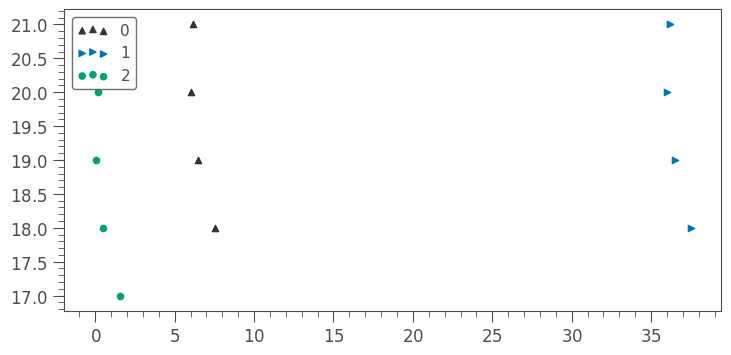

In [12]:
with plt.style.context(ms.ms):
    plt.plot(f, p)
    plt.plot(f, mod.model(init_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.scatter(f0_%deltanu_, n0_, marker='^',label='0', s=20)
    ax.scatter(f1_%deltanu_, n1_, marker='>',label='1', s=20)
    ax.scatter(f2_%deltanu_, n2_, marker='o',label='2', s=20)

    ax.legend()
    plt.show()    

## First lets fit the mode frequencies...

In [14]:
pm_model = pm.Model()


with pm_model:   
    numax = pm.Normal('numax', numax_, 1., testval=numax_)
    deltanu = pm.Normal('deltanu', deltanu_, 1., testval=deltanu_)
    alpha = pm.Normal('alpha', alpha_, 0.001, testval=alpha_)
    epsilon = pm.Normal('epsilon', epsilon_, 1., testval=epsilon_)
    d01     = pm.Normal('d01', d01_, 0.01, testval=d01_)   
    d02     = pm.Normal('d02', d02_, 0.01, testval=d02_)
    
    f0 = pm.Normal('like0', mod.f0([numax, deltanu, alpha, epsilon, d01, d02]), 1.0, observed=f0_)
    f1 = pm.Normal('like1', mod.f1([numax, deltanu, alpha, epsilon, d01, d02]), 1.0, observed=f1_)
    f2 = pm.Normal('like2', mod.f2([numax, deltanu, alpha, epsilon, d01, d02]), 1.0, observed=f2_)

    f0 = pm.Deterministic('f0', mod.f0([numax, deltanu, alpha, epsilon, d01, d02]))
    f1 = pm.Deterministic('f1', mod.f1([numax, deltanu, alpha, epsilon, d01, d02]))
    f2 = pm.Deterministic('f2', mod.f2([numax, deltanu, alpha, epsilon, d01, d02]))
    
    trace = pm.sample(tune=1000,chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [d02, d01, epsilon, alpha, deltanu, numax]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:16<00:00, 366.15draws/s]


In [15]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
numax,1150.009188,0.994226,0.021547,1148.125451,1151.948613,1836.376580,0.999367
deltanu,60.006195,0.177948,0.006268,59.654643,60.344762,954.124236,0.999094
alpha,0.010005,0.000971,0.000024,0.008119,0.011921,1564.709957,0.999786
epsilon,1.097981,0.060948,0.002170,0.975570,1.213033,938.284900,0.999122
d01,0.499914,0.007248,0.000195,0.485091,0.513208,1616.057052,0.999592
d02,0.100093,0.007311,0.000177,0.086533,0.114761,1708.450815,0.999346
f0__0,1147.524646,0.536796,0.016820,1146.449205,1148.511822,1288.165747,0.999764
f0__1,1206.473800,0.401961,0.010724,1205.719467,1207.289097,1522.003428,1.000177
f0__2,1266.023346,0.389554,0.008671,1265.283050,1266.795390,1750.819828,1.000136
f0__3,1326.173283,0.510284,0.013556,1325.219314,1327.144894,1466.674310,0.999619


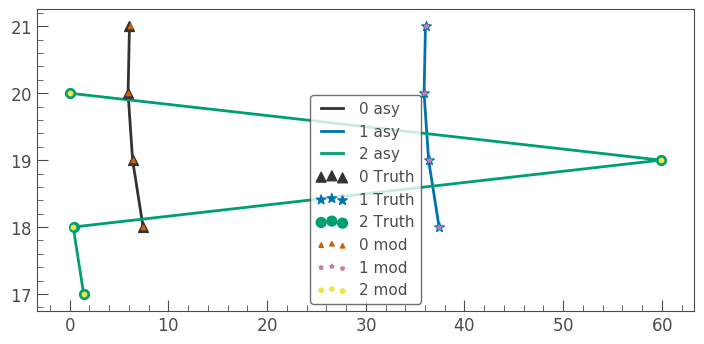

In [20]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'deltanu', 'alpha', 'epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
       
    ax.plot(mod.f0(res)%res[1], n0_, label='0 asy',lw=2, zorder=1)
    ax.plot(mod.f1(res)%res[1], n1_, label='1 asy',lw=2, zorder=1)
    ax.plot(mod.f2(res)%res[1], n2_, label='2 asy',lw=2, zorder=1)

    ax.scatter(f0_%res[1], n0_, marker='^',label='0 Truth',  s=50, zorder=2)
    ax.scatter(f1_%res[1], n1_, marker='*',label='1 Truth',  s=50, zorder=2)
    ax.scatter(f2_%res[1], n2_, marker='o',label='2 Truth',  s=50, zorder=2)      
    
    ax.scatter(resls[0]%res[1], n0_, marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(resls[1]%res[1], n1_, marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(resls[2]%res[1], n2_, marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='best')    

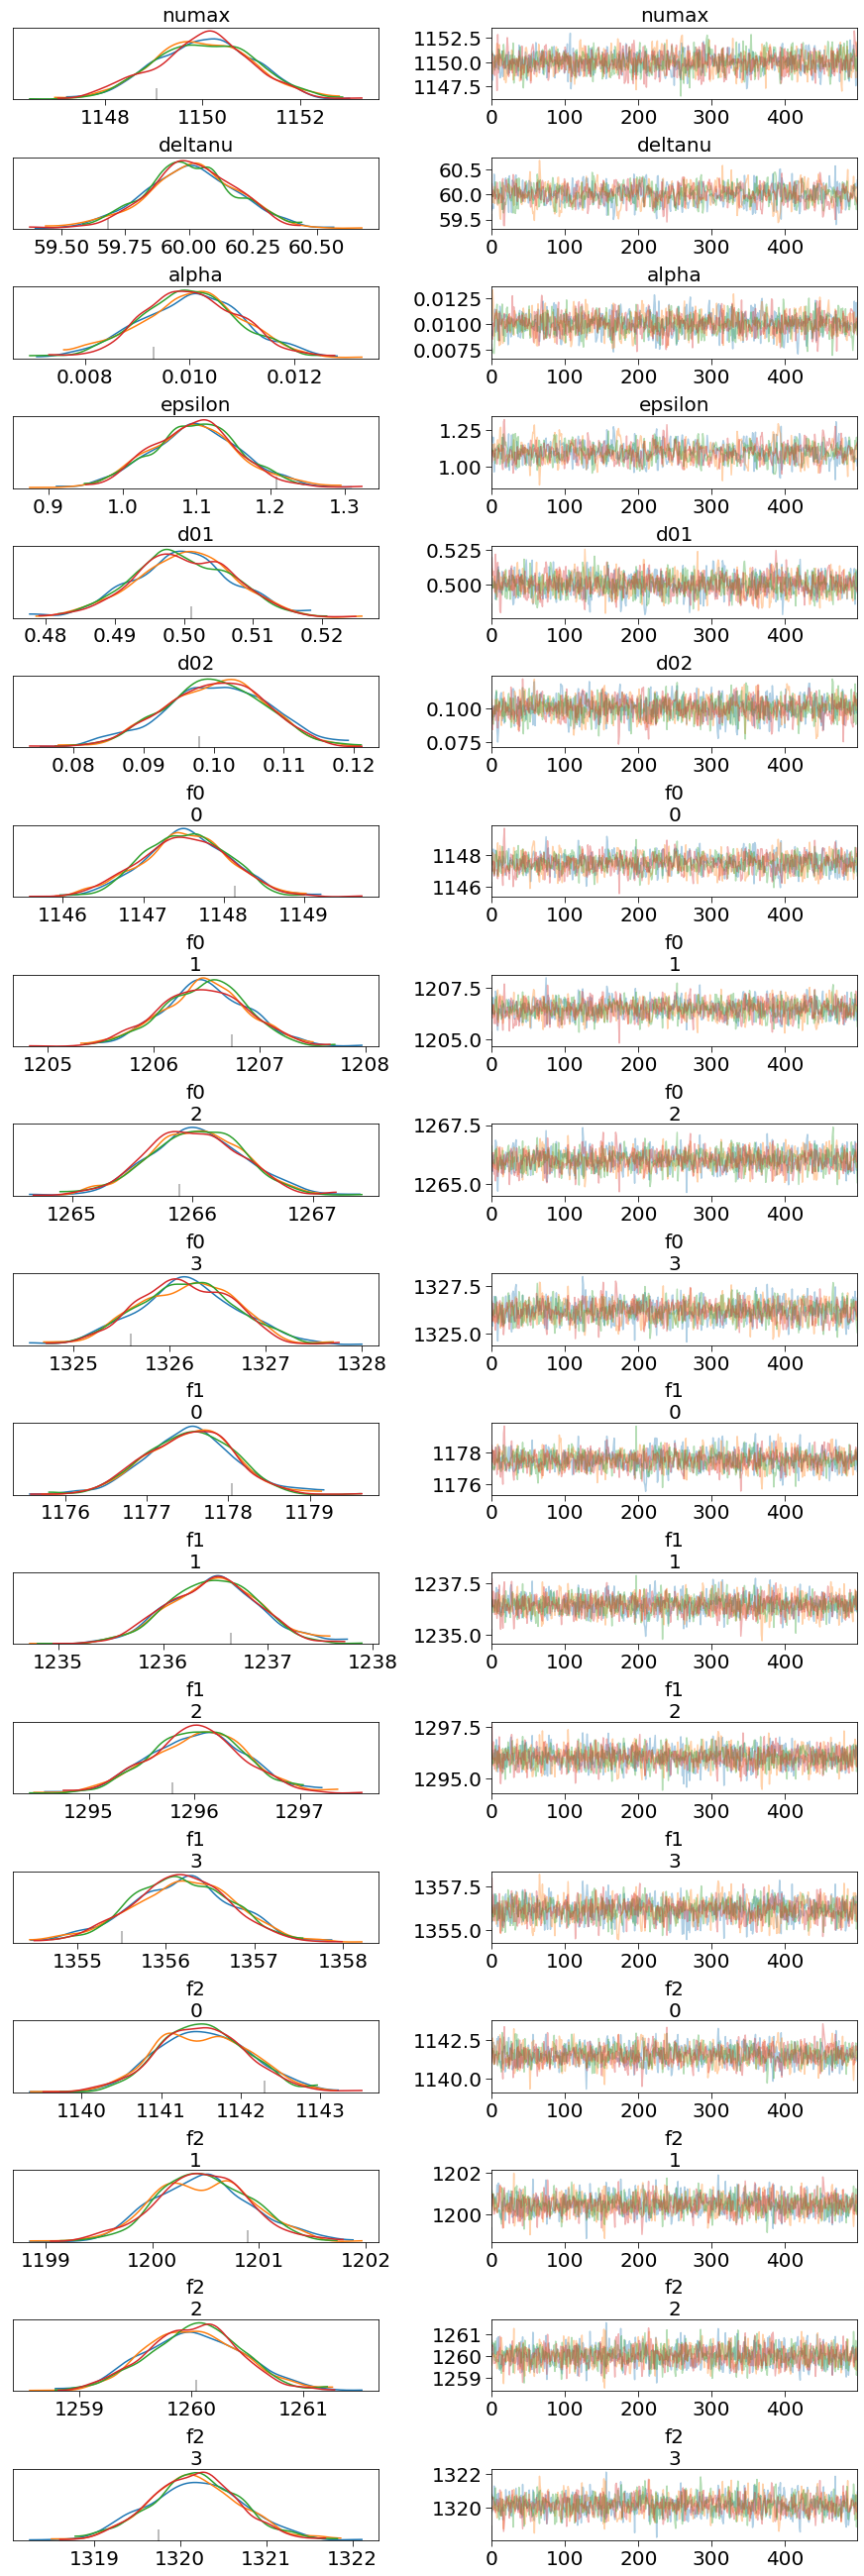

In [21]:
pm.traceplot(trace);

# Now lets try and fit this

In [34]:
pm_model = pm.Model()

BNormal = pm.Bound(pm.Normal, lower=0.)

with pm_model:   
    numax = pm.Normal('numax', numax_, 1., testval=numax_)
    deltanu = pm.Normal('deltanu', deltanu_, 1., testval=deltanu_)
    alpha = pm.Normal('alpha', alpha_, 0.001, testval=alpha_)
    epsilon = pm.Normal('epsilon', epsilon_, 1., testval=epsilon_)
    d01     = pm.Normal('d01', d01_, 0.01, testval=d01_)   
    d02     = pm.Normal('d02', d02_, 0.01, testval=d02_)
    
    f0 = pm.Normal('f0', mod.f0([numax, deltanu, alpha, epsilon, d01, d02]), 1.0, shape=len(n0_))
    f1 = pm.Normal('f1', mod.f1([numax, deltanu, alpha, epsilon, d01, d02]), 1.0, shape=len(n0_))
    f2 = pm.Normal('f2', mod.f2([numax, deltanu, alpha, epsilon, d01, d02]), 1.0, shape=len(n0_))
        
    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init_m[3], shape=len(init_m[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init_m[4], shape=len(init_m[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init_m[5], shape=len(init_m[5]))

    a0 = pm.HalfNormal('a0', sigma=20., testval=init_m[6], shape=len(init_m[6]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=init_m[7], shape=len(init_m[7]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=init_m[8], shape=len(init_m[8]))
    
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    b = BNormal('b', mu=1., sigma=.1, testval=1.)
    
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)

In [35]:
with pm_model:
    trace = pm.sample(tune=1000, chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [b, cosi, xsplit, a2, a1, a0, g2, g1, g0, f2, f1, f0, d02, d01, epsilon, alpha, deltanu, numax]
Sampling 4 chains: 100%|██████████| 6000/6000 [13:56<00:00,  4.08draws/s] 


In [36]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
numax,1149.972973,1.019293,0.016815,1148.111793,1151.999182,3666.899778,0.999597
deltanu,59.921617,0.197290,0.004581,59.509637,60.278866,1674.564265,1.000171
alpha,0.009989,0.000988,0.000015,0.008063,0.011878,3467.506879,0.999133
epsilon,1.125657,0.067350,0.001561,0.996070,1.257195,1694.617005,1.000021
d01,0.500766,0.007312,0.000129,0.486358,0.515054,3224.079221,1.000210
d02,0.099433,0.007448,0.000135,0.084988,0.113918,2933.741919,1.000209
f0__0,1147.669179,0.118957,0.002175,1147.430655,1147.901946,2521.826170,0.999424
f0__1,1206.340015,0.146206,0.003041,1206.069217,1206.632919,2597.667954,0.999872
f0__2,1266.072323,0.187106,0.004820,1265.710926,1266.435893,1556.604206,1.000601
f0__3,1325.649264,0.202949,0.004943,1325.271802,1326.064233,1739.448412,1.003896


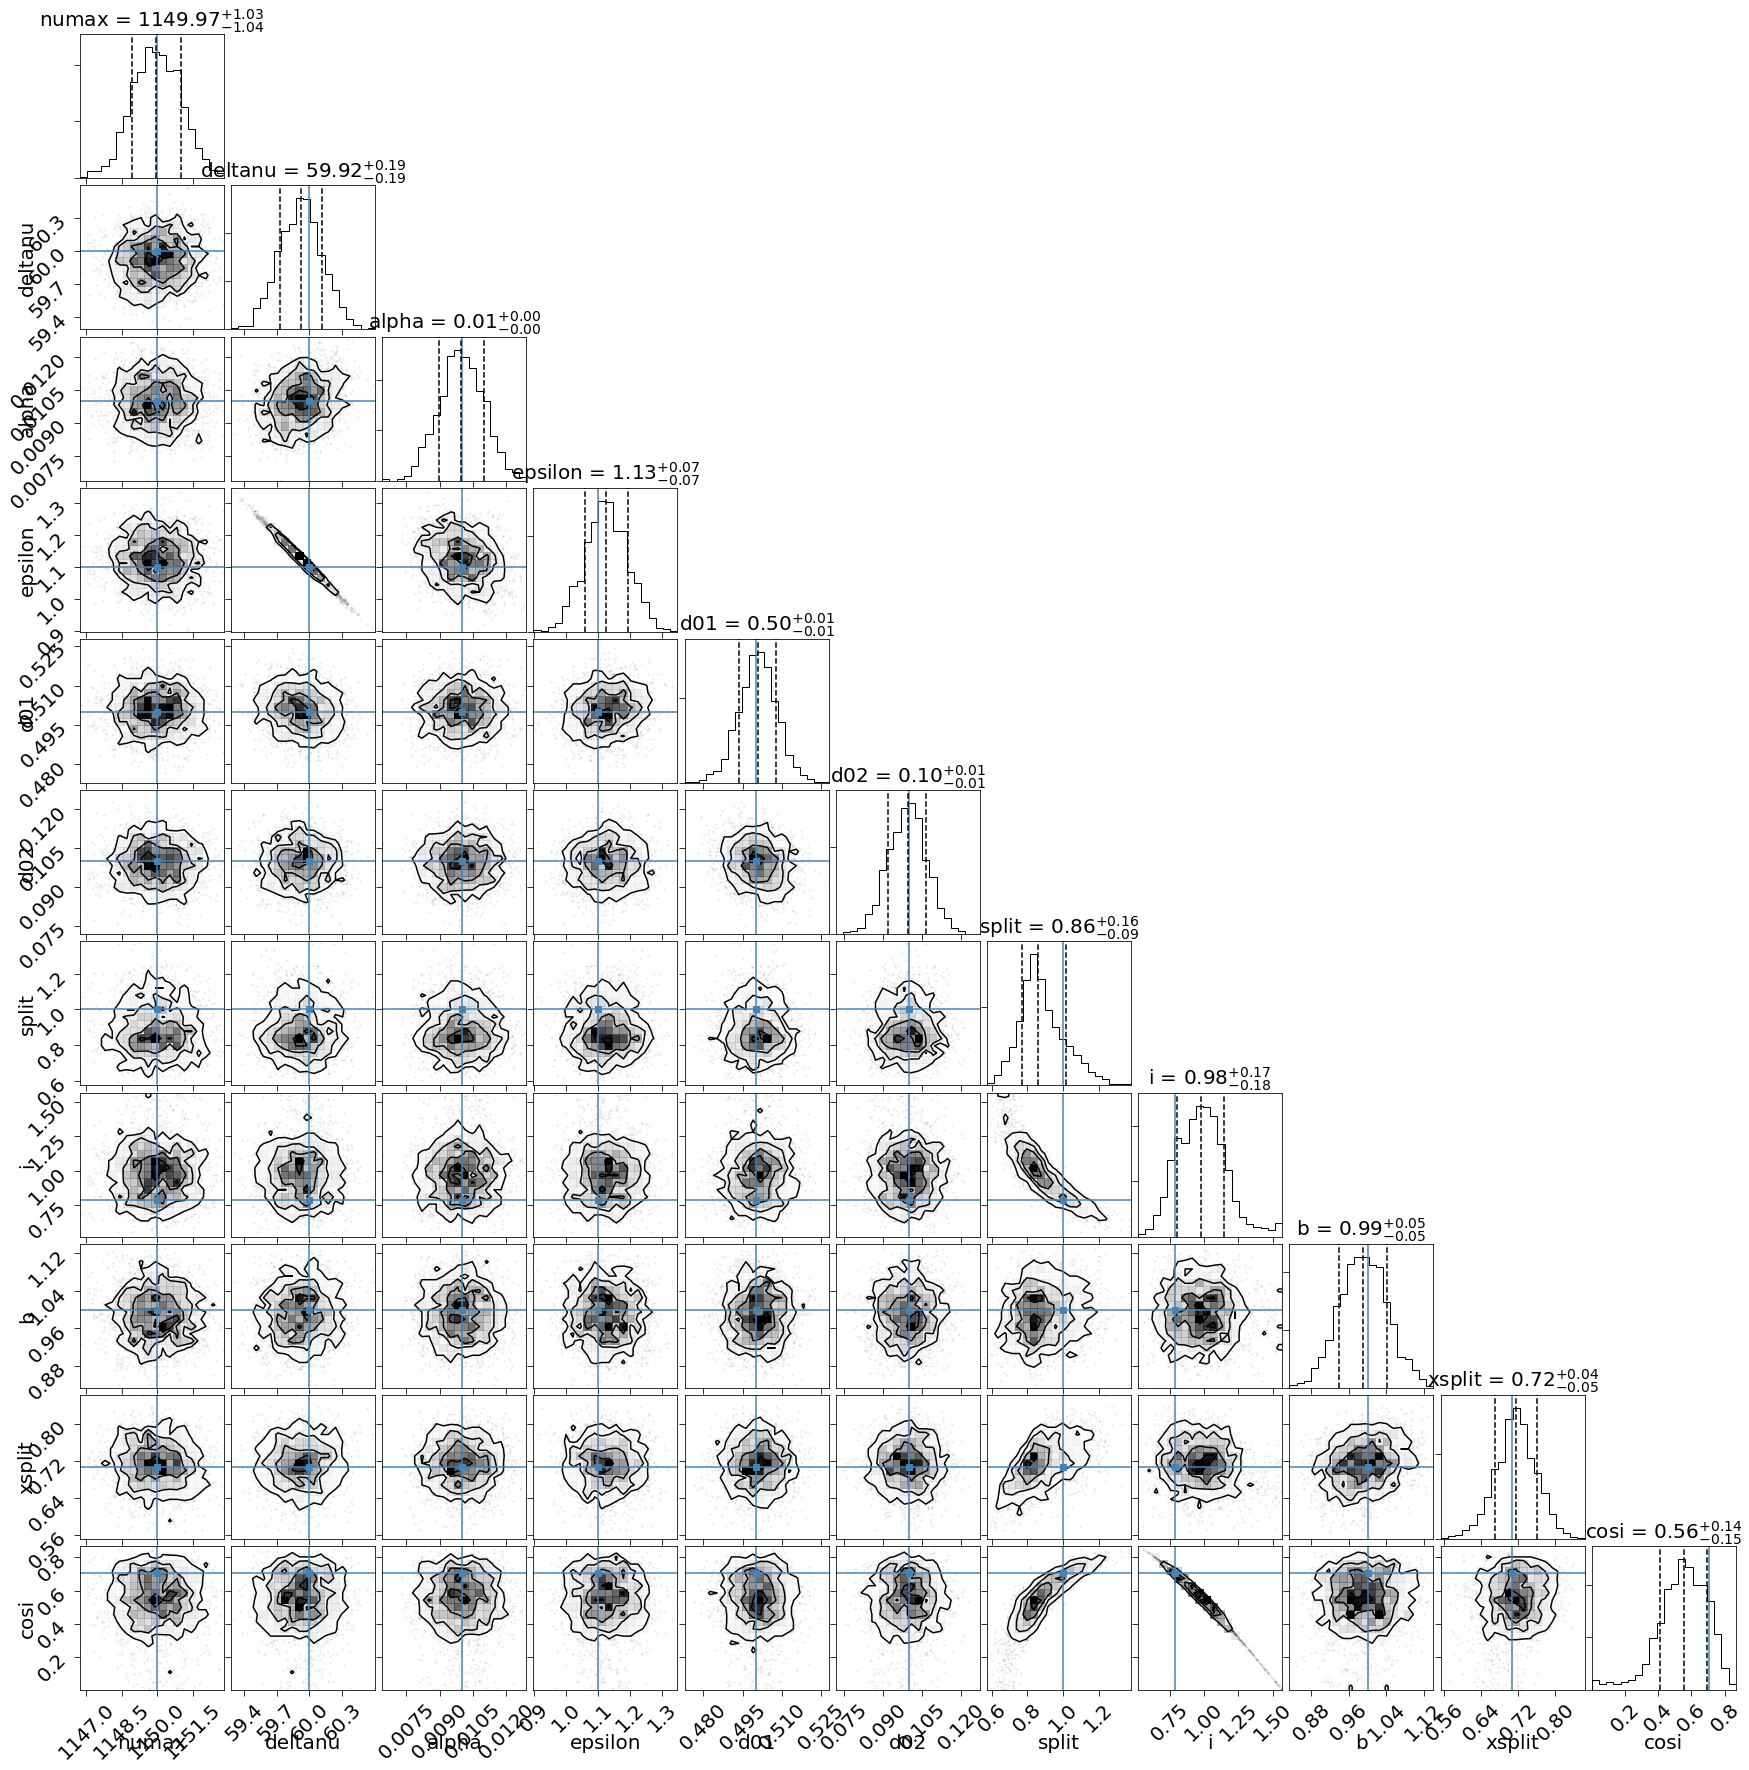

In [40]:
labels = ['numax','deltanu','alpha','epsilon','d01','d02','split','i','b','xsplit','cosi']
chain = np.array([trace[label] for label in labels])
truths = [numax_, deltanu_, alpha_, epsilon_, d01_, d02_,
         init_m[9], init_m[10], init_m[11], init_m[9]*np.sin(init_m[10]), np.cos(init_m[10])]
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[.16, .5, .84], show_titles=True)
plt.show()

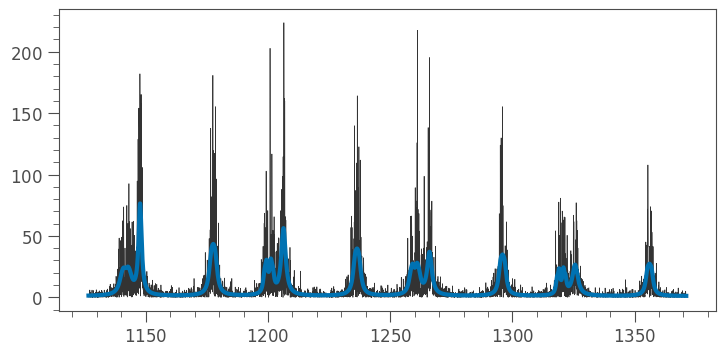

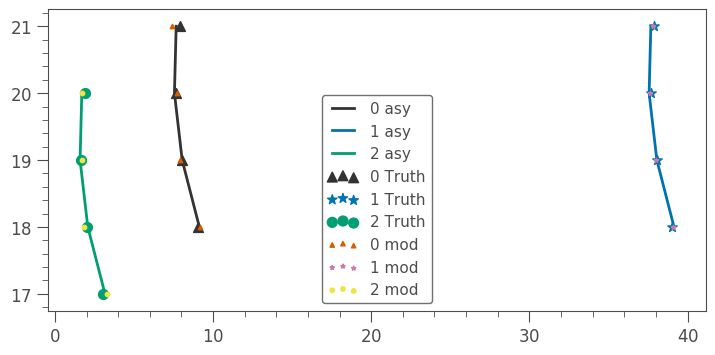

In [41]:
with plt.style.context(ms.ms):
    res_m = [np.median(trace[label], axis=0) for label in ['f0','f1','f2','g0','g1','g2',
                                                         'h0','h1','h2','split','i','b']]
    plt.plot(f, p)
    plt.plot(f, mod.model(res_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax','deltanu','alpha','epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
       
    ax.plot(mod.f0(res)%res[1], n0_, label='0 asy',lw=2, zorder=1)
    ax.plot(mod.f1(res)%res[1], n1_, label='1 asy',lw=2, zorder=1)
    ax.plot(mod.f2(res)%res[1], n2_, label='2 asy',lw=2, zorder=1)

    ax.scatter(f0_%res[1], n0_, marker='^',label='0 Truth',  s=50, zorder=2)
    ax.scatter(f1_%res[1], n1_, marker='*',label='1 Truth',  s=50, zorder=2)
    ax.scatter(f2_%res[1], n2_, marker='o',label='2 Truth',  s=50, zorder=2)      
    
    ax.scatter(resls[0]%res[1], n0_, marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(resls[1]%res[1], n1_, marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(resls[2]%res[1], n2_, marker='o',label='2 mod', s=10, zorder=3)  
    
    ax.legend(loc='best')   

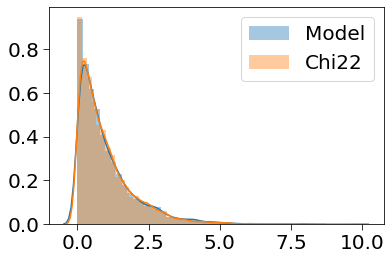

In [42]:
residual = p/mod.model(res_m, theano=False)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
plt.legend()